In [1]:
from analysis.get_dataframe_from_results import get_pandas_dataset
from analysis.dataset_graphs import plot_graphs_of_dataset_loc
from analysis.get_tables_results import create_table_cleaned
from analysis.get_results import bar_chart_fix_position_cleaned
from analysis.get_results import sucess_vs_position_cleaned

import utils.global_variables as gl
import pandas as pd

pd.set_option('display.max_columns', None)

# Show all rows (careful if you have a huge DataFrame)
pd.set_option('display.max_rows', None)

# Don't truncate wide column contents
pd.set_option('display.max_colwidth', None)

# Make the output use the full notebook width
pd.set_option('display.width', None)

BASE_PATH: /home/ricostynha/Desktop/dafny_assertion_inference


In [2]:
RESULT_DIR = gl.LLM_RESULTS_DIR
DATASET_DIR = gl.DAFNY_ASSERTION_DATASET

RESULT_DIR_ALL_ONE_TWO_MAX = gl.BASE_PATH / "results/dafny_llm_results_dataset_multi_generate_1_or_2"
DATASET_DIR_ALL_ONE_TWO_MAX = gl.BASE_PATH / "dataset/dafny_assertion_dataset_multi_generate_1_or_2"

verif_data_pd = get_pandas_dataset(DATASET_DIR, RESULT_DIR)
verif_data_all_one_two_pd = get_pandas_dataset(DATASET_DIR_ALL_ONE_TWO_MAX, RESULT_DIR_ALL_ONE_TWO_MAX)

# Uncomment to get results for a given number of a
# No tests were performed in this testbenches they were not included
verif_data_pd = verif_data_pd[
    (verif_data_pd['benchmark'] != "w/o-2 one w/o-1") 
]
verif_data_all_one_two_pd = verif_data_all_one_two_pd[
    (verif_data_all_one_two_pd['benchmark'] != "w/o-2 one w/o-1") 
]

verif_data_pd  = verif_data_pd.assign(success=lambda d: d['verif_sucess'] > 0) 
verif_data_all_one_two_pd  = verif_data_all_one_two_pd.assign(success=lambda d: d['verif_sucess'] > 0) 

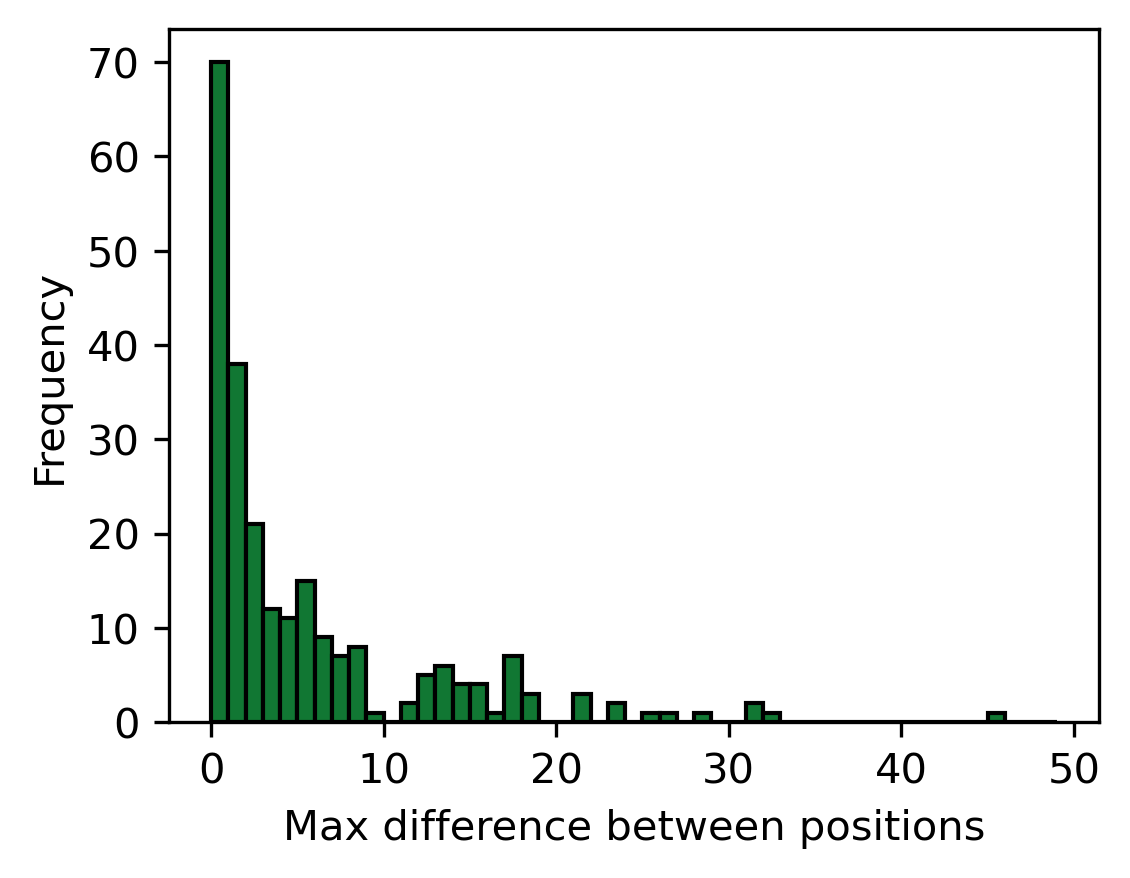

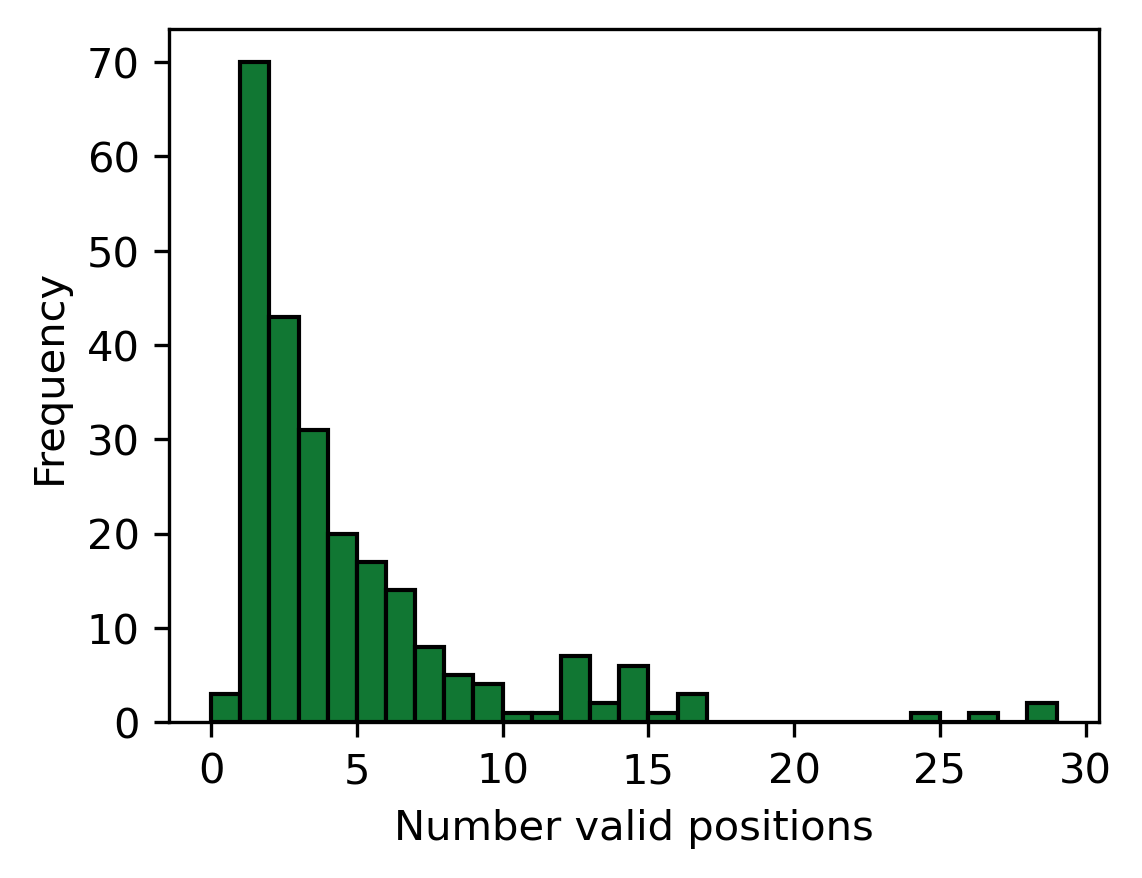

In [3]:
# Distribuion of valid positions and distance betwwen maximums

plot_graphs_of_dataset_loc(DATASET_DIR, gl.BASE_PATH / "images")

In [4]:
# Distribution of helper assertions 
# Best Combinations OVerall
best_models={ 
                 "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_3_alpha_0.5_ExType_DYNAMIC_loc_LAUREL_BETTER" : "STATIC_RAG",
                 "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_3_alpha_0.5_ExType_DYNAMIC_loc_LLM_EXAMPLE" : "LLM_EX_RAG", 
                 "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_3_alpha_0.5_ExType_DYNAMIC_loc_ORACLE" : "ORACLE_RAG" ,                         
                  }
        
best_model_1_assertion = verif_data_pd [verif_data_pd["benchmark"] == "w/o-1"]
  
# Apply renaming before grouping
best_model_1_assertion["llm"] = best_model_1_assertion["llm"].map(best_models)

df_pairs = best_model_1_assertion.groupby(
        ['llm', 'prog','group'],
        as_index=False
    ).agg(
        assertion_type=('assertion_type', lambda x: str(x.iloc[0])),
        oracle_here_would_fix=('oracle_here_would_fix', lambda x: any(x)),
        assertion_here_syntatic_valid=('assertion_here_syntatic_valid', lambda x: any(x)),
        number_expected_assertions=('number_expected_assertions', lambda x: sum(x)),
        benchmark=('benchmark', lambda x: str(x.iloc[0])),
        success=('success','any')
    )

print("Distribution of Helper Assertions")
counts = df_pairs.groupby(['llm','assertion_type']).size().reset_index(name='count')
print(counts)

print("Distribution of Helper Assertions per Success")
counts = df_pairs.groupby(['llm','assertion_type', 'success']).size().reset_index(name='count')
print(counts)

Distribution of Helper Assertions
           llm assertion_type  count
0   LLM_EX_RAG      ['INDEX']     69
1   LLM_EX_RAG      ['MULTI']     12
2   LLM_EX_RAG      ['OTHER']    127
3   LLM_EX_RAG       ['TEST']     33
4   ORACLE_RAG      ['INDEX']     69
5   ORACLE_RAG      ['MULTI']     12
6   ORACLE_RAG      ['OTHER']    127
7   ORACLE_RAG       ['TEST']     33
8   STATIC_RAG      ['INDEX']     69
9   STATIC_RAG      ['MULTI']     12
10  STATIC_RAG      ['OTHER']    127
11  STATIC_RAG       ['TEST']     33
Distribution of Helper Assertions per Success
           llm assertion_type  success  count
0   LLM_EX_RAG      ['INDEX']    False     31
1   LLM_EX_RAG      ['INDEX']     True     38
2   LLM_EX_RAG      ['MULTI']    False      9
3   LLM_EX_RAG      ['MULTI']     True      3
4   LLM_EX_RAG      ['OTHER']    False     67
5   LLM_EX_RAG      ['OTHER']     True     60
6   LLM_EX_RAG       ['TEST']    False     10
7   LLM_EX_RAG       ['TEST']     True     23
8   ORACLE_RAG      ['IND

/tmp/ipykernel_192282/172936108.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_model_1_assertion["llm"] = best_model_1_assertion["llm"].map(best_models)


In [5]:


# Models for finding example retrieval
assert_inference_models ={
                  "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_3_ExType_RANDOM_loc_ORACLE" : "random",
                  "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_0_ExType_NONE_loc_ORACLE" : "no example",
                  "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_3_alpha_0.25_ExType_DYNAMIC_loc_ORACLE" : "alpha_0.25",
                  "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_3_alpha_1_ExType_DYNAMIC_loc_ORACLE" : "alpha_1",
                  "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_3_alpha_0.75_ExType_DYNAMIC_loc_ORACLE" : "alpha_0.75",
                  "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_3_ExType_TFIDF_loc_ORACLE"   : "tfidf",  
                  "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_3_alpha_0.5_ExType_DYNAMIC_loc_ORACLE" : "alpha_0.50" ,   
                  "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_3_ExType_EMBEDDED_loc_ORACLE" : "EMBEDDED"                                                              
                  }
    
# Models for finding best fault localization
fault_loc_models={ 
                 "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_0_ExType_NONE_loc_LAUREL" : "Laurel$_{fl}$",
                 "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_0_ExType_NONE_loc_LLM" : "Llm$_{fl}$", 
                 "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_0_ExType_NONE_loc_LAUREL_BETTER" : "Laurel$_{fl+}$",
                 "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_0_ExType_NONE_loc_LLM_EXAMPLE" : "LlmEx$_{fl}$",
                 "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_0_ExType_NONE_loc_ORACLE" : "GrTru$_{fl}$",               
                  }  

In [6]:
# This creates the values for most tables of the paper that contatins results

print("The results of All on assertions here is runned without limitations (it is not the one that appears on the paper tables)")
print("Results for Best Models")
create_table_cleaned(verif_data_pd, best_models)
print("Results for finding example retrieval")
create_table_cleaned(verif_data_pd, assert_inference_models)
print("Results for fault localizaiton")
create_table_cleaned(verif_data_pd, fault_loc_models)


print("For these all matter the results for all (the others are depreceated by the previous, the all results are the ones that appear on the tables on the paper with restriction of maximum 2 assertion asked)")
print("Results for Best Models")
create_table_cleaned(verif_data_all_one_two_pd , best_models)
print("Results for finding example retrieval")
create_table_cleaned(verif_data_all_one_two_pd , assert_inference_models)
print("Results for fault localizaiton")
create_table_cleaned(verif_data_all_one_two_pd , fault_loc_models)

The results of All on assertions here is runned without limitations (it is not the one that appears on the paper tables)
Results for Best Models
LLM_EX_RAG:1:124:51.5%:241
LLM_EX_RAG:2:70:29.8%:235
LLM_EX_RAG:all:6:20.0%:30
ORACLE_RAG:1:160:66.4%:241
ORACLE_RAG:2:85:36.2%:235
ORACLE_RAG:all:8:26.7%:30
STATIC_RAG:1:125:51.9%:241
STATIC_RAG:2:54:23.0%:235
STATIC_RAG:all:4:13.3%:30
Results for finding example retrieval
EMBEDDED:1:164:68.0%:241
EMBEDDED:2:82:34.9%:235
EMBEDDED:all:7:23.3%:30
alpha_0.25:1:151:62.7%:241
alpha_0.25:2:75:31.9%:235
alpha_0.25:all:8:26.7%:30
alpha_0.50:1:160:66.4%:241
alpha_0.50:2:85:36.2%:235
alpha_0.50:all:8:26.7%:30
alpha_0.75:1:157:65.1%:241
alpha_0.75:2:86:36.6%:235
alpha_0.75:all:9:30.0%:30
alpha_1:1:150:62.2%:241
alpha_1:2:83:35.3%:235
alpha_1:all:8:26.7%:30
no example:1:124:51.5%:241
no example:2:79:33.6%:235
no example:all:6:20.0%:30
random:1:124:51.5%:241
random:2:75:31.9%:235
random:all:9:30.0%:30
tfidf:1:158:65.6%:241
tfidf:2:79:33.6%:235
tfidf:all:1

In [7]:
# Get the performance of the ensemble of laurel+ and llm Example
ensemble_model = verif_data_pd [verif_data_pd["llm"].isin([
        "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_3_alpha_0.5_ExType_DYNAMIC_loc_LAUREL_BETTER",
        "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_3_alpha_0.5_ExType_DYNAMIC_loc_LLM_EXAMPLE"
])]

df_pairs = ensemble_model.groupby(
        ['prog','group'],
        as_index=False
    ).agg(
        assertion_type=('assertion_type', lambda x: str(x.iloc[0])),
        oracle_here_would_fix=('oracle_here_would_fix', lambda x: any(x)),
        assertion_here_syntatic_valid=('assertion_here_syntatic_valid', lambda x: any(x)),
        number_expected_assertions=('number_expected_assertions', lambda x: sum(x)),
        benchmark=('benchmark', lambda x: str(x.iloc[0])),
        success=('success','any')
    )


counts = df_pairs.groupby(['success','benchmark']).size().reset_index(name='count')
print("Ensemble model efficacy (to get w/o-2 you must add the values of( w/o-2 both w/o-1 and  w/o-2 none w/o-1):")
print("The value of the All asertion dataset displayed does not correspond to the actual on the paper as this does not restricct number of assertion generated")
print(counts)


# Get the performance of the ensemble of laurel+ and llm Example
ensemble_model_all_one_two = verif_data_all_one_two_pd [verif_data_all_one_two_pd["llm"].isin([
        "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_3_alpha_0.5_ExType_DYNAMIC_loc_LAUREL_BETTER",
        "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_3_alpha_0.5_ExType_DYNAMIC_loc_LLM_EXAMPLE"
])]

df_pairs = ensemble_model_all_one_two.groupby(
        ['prog','group'],
        as_index=False
    ).agg(
        assertion_type=('assertion_type', lambda x: str(x.iloc[0])),
        oracle_here_would_fix=('oracle_here_would_fix', lambda x: any(x)),
        assertion_here_syntatic_valid=('assertion_here_syntatic_valid', lambda x: any(x)),
        number_expected_assertions=('number_expected_assertions', lambda x: sum(x)),
        benchmark=('benchmark', lambda x: str(x.iloc[0])),
        success=('success','any')
    )


counts = df_pairs.groupby(['success','benchmark']).size().reset_index(name='count')
print("Ensemble model efficacy (to get w/o-2 you must add the values of( w/o-2 both w/o-1 and  w/o-2 none w/o-1):")
print("Consider Only the value for the ALL dataset, is the one on the results of the paper (correponds to the restriction max 2)")
print(counts)




Ensemble model efficacy (to get w/o-2 you must add the values of( w/o-2 both w/o-1 and  w/o-2 none w/o-1):
The value of the All asertion dataset displayed does not correspond to the actual on the paper as this does not restricct number of assertion generated
   success         benchmark  count
0    False             w/o-1     88
1    False  w/o-2 both w/o-1    152
2    False  w/o-2 none w/o-1      7
3    False           w/o-all     23
4     True             w/o-1    153
5     True  w/o-2 both w/o-1     20
6     True  w/o-2 none w/o-1     56
7     True           w/o-all      7
Ensemble model efficacy (to get w/o-2 you must add the values of( w/o-2 both w/o-1 and  w/o-2 none w/o-1):
Consider Only the value for the ALL dataset, is the one on the results of the paper (correponds to the restriction max 2)
   success         benchmark  count
0    False             w/o-1     87
1    False  w/o-2 none w/o-1      6
2    False           w/o-all     22
3     True             w/o-1    151
4     Tr

In [8]:
# Distribution of helper assertions for best models in w/o-2 datasets
best_models={ 
                 "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_3_alpha_0.5_ExType_DYNAMIC_loc_LAUREL_BETTER" : "STATIC_RAG",
                 "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_3_alpha_0.5_ExType_DYNAMIC_loc_LLM_EXAMPLE" : "LLM_EX_RAG", 
                 "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_3_alpha_0.5_ExType_DYNAMIC_loc_ORACLE" : "ORACLE_RAG" ,                         
                  }
        
best_model_2_assertion = verif_data_pd [verif_data_pd["benchmark"].isin([
        "w/o-2 both w/o-1",
        "w/o-2 none w/o-1"
    ])]
  
best_model_2_assertion ["llm"] = best_model_2_assertion ["llm"].map(best_models)
  
df_pairs =  best_model_2_assertion .groupby(
        ['llm','prog','group'],
        as_index=False
    ).agg(
        assertion_type=('assertion_type', lambda x: str(x.iloc[-1])),
        oracle_here_would_fix=('oracle_here_would_fix', lambda x: any(x)),
        assertion_here_syntatic_valid=('assertion_here_syntatic_valid', lambda x: any(x)),
        number_expected_assertions=('number_expected_assertions', lambda x: x.iloc[-1]),
        number_oracle_assertions=('number_oracle_assertions', lambda x: x.iloc[-1]),
        benchmark=('benchmark', lambda x: x.iloc[-1]),
        success=('success','any')
    )

#print(df_pairs)
counts = df_pairs.groupby(["llm", "benchmark", 'success']).size().reset_index(name='count')
print("Counts per assertion benchmark:")
print(counts)

ensemble_model_all_one_two = best_model_2_assertion [best_model_2_assertion["llm"].isin([
        "STATIC_RAG",
        "LLM_EX_RAG"
])]

df_pairs = ensemble_model_all_one_two.groupby(
        ['prog','group'],
        as_index=False
    ).agg(
        assertion_type=('assertion_type', lambda x: str(x.iloc[0])),
        oracle_here_would_fix=('oracle_here_would_fix', lambda x: any(x)),
        assertion_here_syntatic_valid=('assertion_here_syntatic_valid', lambda x: any(x)),
        number_expected_assertions=('number_expected_assertions', lambda x: sum(x)),
        benchmark=('benchmark', lambda x: str(x.iloc[0])),
        success=('success','any')
    )


counts = df_pairs.groupby(['success','benchmark']).size().reset_index(name='count')
print("Ensemble model efficacy (to get w/o-2 you must ass the values of( w/o-2 both w/o-1 and  w/o-2 none w/o-1):")
print("Consider Only the value for the all dataset, is the one on the results of the paper (correponds to the restriction max 2)")
print(counts)






Counts per assertion benchmark:
           llm         benchmark  success  count
0   LLM_EX_RAG  w/o-2 both w/o-1    False    155
1   LLM_EX_RAG  w/o-2 both w/o-1     True     17
2   LLM_EX_RAG  w/o-2 none w/o-1    False     10
3   LLM_EX_RAG  w/o-2 none w/o-1     True     53
4   ORACLE_RAG  w/o-2 both w/o-1    False    139
5   ORACLE_RAG  w/o-2 both w/o-1     True     33
6   ORACLE_RAG  w/o-2 none w/o-1    False     11
7   ORACLE_RAG  w/o-2 none w/o-1     True     52
8   STATIC_RAG  w/o-2 both w/o-1    False    164
9   STATIC_RAG  w/o-2 both w/o-1     True      8
10  STATIC_RAG  w/o-2 none w/o-1    False     17
11  STATIC_RAG  w/o-2 none w/o-1     True     46
Ensemble model efficacy (to get w/o-2 you must ass the values of( w/o-2 both w/o-1 and  w/o-2 none w/o-1):
Consider Only the value for the all dataset, is the one on the results of the paper (correponds to the restriction max 2)
   success         benchmark  count
0    False  w/o-2 both w/o-1    152
1    False  w/o-2 none w/o-1  

/tmp/ipykernel_192282/307044496.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_model_2_assertion ["llm"] = best_model_2_assertion ["llm"].map(best_models)


In [9]:
# assert-all complete overview of number of assertion expected vs oracle
best_model_1_assertion = verif_data_pd [verif_data_pd["llm"].isin([
         "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_3_alpha_0.5_ExType_DYNAMIC_loc_LLM_EXAMPLE"
])]

        
best_model_1_assertion = best_model_1_assertion  [best_model_1_assertion ["benchmark"] == "w/o-all"]
  
df_pairs = best_model_1_assertion.groupby(
        ['prog','group'],
        as_index=False
    ).agg(
        assertion_type=('assertion_type', lambda x: str(x.iloc[0])),
        oracle_here_would_fix=('oracle_here_would_fix', lambda x: any(x)),
        assertion_here_syntatic_valid=('assertion_here_syntatic_valid', lambda x: any(x)),
        number_expected_assertions=('number_expected_assertions', lambda x: int(x.iloc[0])),
        number_oracle_assertions=('number_oracle_assertions', lambda x: int(x.iloc[0])),
        benchmark=('benchmark', lambda x: str(x.iloc[0])),
        success=('success','any')
    )

print("w/o-all number of oracle assertions vs expected assertion (without restriction of two max)")
counts = df_pairs.groupby(['number_oracle_assertions', 'number_expected_assertions', "success"]).size().reset_index(name='count')
print(counts)

# assert-all complete overview of number of assertion expected vs oracle
best_model_1_assertion = verif_data_all_one_two_pd [verif_data_all_one_two_pd["llm"].isin([
         "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_3_alpha_0.5_ExType_DYNAMIC_loc_LLM_EXAMPLE"
])]

        
best_model_1_assertion = best_model_1_assertion  [best_model_1_assertion ["benchmark"] == "w/o-all"]
  
df_pairs = best_model_1_assertion.groupby(
        ['prog','group'],
        as_index=False
    ).agg(
        assertion_type=('assertion_type', lambda x: str(x.iloc[0])),
        oracle_here_would_fix=('oracle_here_would_fix', lambda x: any(x)),
        assertion_here_syntatic_valid=('assertion_here_syntatic_valid', lambda x: any(x)),
        number_expected_assertions=('number_expected_assertions', lambda x: int(x.iloc[0])),
        number_oracle_assertions=('number_oracle_assertions', lambda x: int(x.iloc[0])),
        benchmark=('benchmark', lambda x: str(x.iloc[0])),
        success=('success','any')
    )

print("w/o-all number of oracle assertions vs expected assertion (with restriction of two max)")
counts = df_pairs.groupby(['number_oracle_assertions', 'number_expected_assertions', "success"]).size().reset_index(name='count')
print(counts)


w/o-all number of oracle assertions vs expected assertion (without restriction of two max)
    number_oracle_assertions  number_expected_assertions  success  count
0                          3                           1    False      5
1                          3                           2    False      2
2                          3                           2     True      1
3                          4                           1    False      2
4                          4                           2    False      2
5                          4                           4     True      2
6                          5                           1    False      1
7                          5                           2    False      1
8                          5                           3    False      1
9                          6                           1    False      1
10                         6                           2     True      1
11                         6     

In [10]:
# graphs refering to the position

#fault_loc_models={ 
#                 "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_0_ExType_NONE_loc_LAUREL" : "Laurel$_{fl}$",
#                 "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_0_ExType_NONE_loc_LLM" : "Llm$_{fl}$", 
#                 "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_0_ExType_NONE_loc_LAUREL_BETTER" : "Laurel$_{fl+}$",
#                 "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_0_ExType_NONE_loc_LLM_EXAMPLE" : "LlmEx$_{fl}$",
#                 "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_0_ExType_NONE_loc_ORACLE" : "GrTru$_{fl}$",               
#                  }  


fault_loc_models={ 
                 "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_0_ExType_NONE_loc_LLM" : "Llm$_{fl}$", 
                 "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_0_ExType_NONE_loc_LLM_EXAMPLE" : "LlmEx$_{fl}$"            
                  }  

# assert-all complete overview of number of assertion expected vs oracle
fault_position = verif_data_pd [verif_data_pd["llm"].isin(fault_loc_models.keys())]

fault_position  ["llm"] = fault_position ["llm"].map(fault_loc_models)

fault_position = fault_position  [(fault_position ["benchmark"] == "w/o-1") | 
                                  (fault_position ["benchmark"] == "w/o-2 both w/o-1") |
                                  (fault_position ["benchmark"] == "w/o-2 none w/o-1")
                                  ]
  
df_pairs = fault_position .groupby(
        ["llm",'prog','group'],
        as_index=False
    ).agg(
        assertion_type=('assertion_type', lambda x: str(x.iloc[0])),
        oracle_here_would_fix=('oracle_here_would_fix', lambda x: any(x)),
        assertion_here_syntatic_valid=('assertion_here_syntatic_valid', lambda x: any(x)),
        number_expected_assertions=('number_expected_assertions', lambda x: int(x.iloc[0])),
        number_oracle_assertions=('number_oracle_assertions', lambda x: int(x.iloc[0])),
        benchmark=('benchmark', lambda x: str(x.iloc[0])),
        success=('success','any')
    )


print("Number of predicted assertions in relationship with ground truth)")
counts = df_pairs.groupby(["llm",'number_oracle_assertions', 'number_expected_assertions']).size().reset_index(name='count')
print(counts)

print("Number of predicted assertions in relationship with ground truth)")
counts = df_pairs.groupby(["llm","benchmark",'number_oracle_assertions', 'number_expected_assertions']).size().reset_index(name='count')
print(counts)


Number of predicted assertions in relationship with ground truth)
            llm  number_oracle_assertions  number_expected_assertions  count
0    Llm$_{fl}$                         1                           1    219
1    Llm$_{fl}$                         1                           2     22
2    Llm$_{fl}$                         2                           1    139
3    Llm$_{fl}$                         2                           2     96
4  LlmEx$_{fl}$                         1                           1    231
5  LlmEx$_{fl}$                         1                           2     10
6  LlmEx$_{fl}$                         2                           1    148
7  LlmEx$_{fl}$                         2                           2     87
Number of predicted assertions in relationship with ground truth)
             llm         benchmark  number_oracle_assertions  \
0     Llm$_{fl}$             w/o-1                         1   
1     Llm$_{fl}$             w/o-1             

/tmp/ipykernel_192282/691636977.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fault_position  ["llm"] = fault_position ["llm"].map(fault_loc_models)


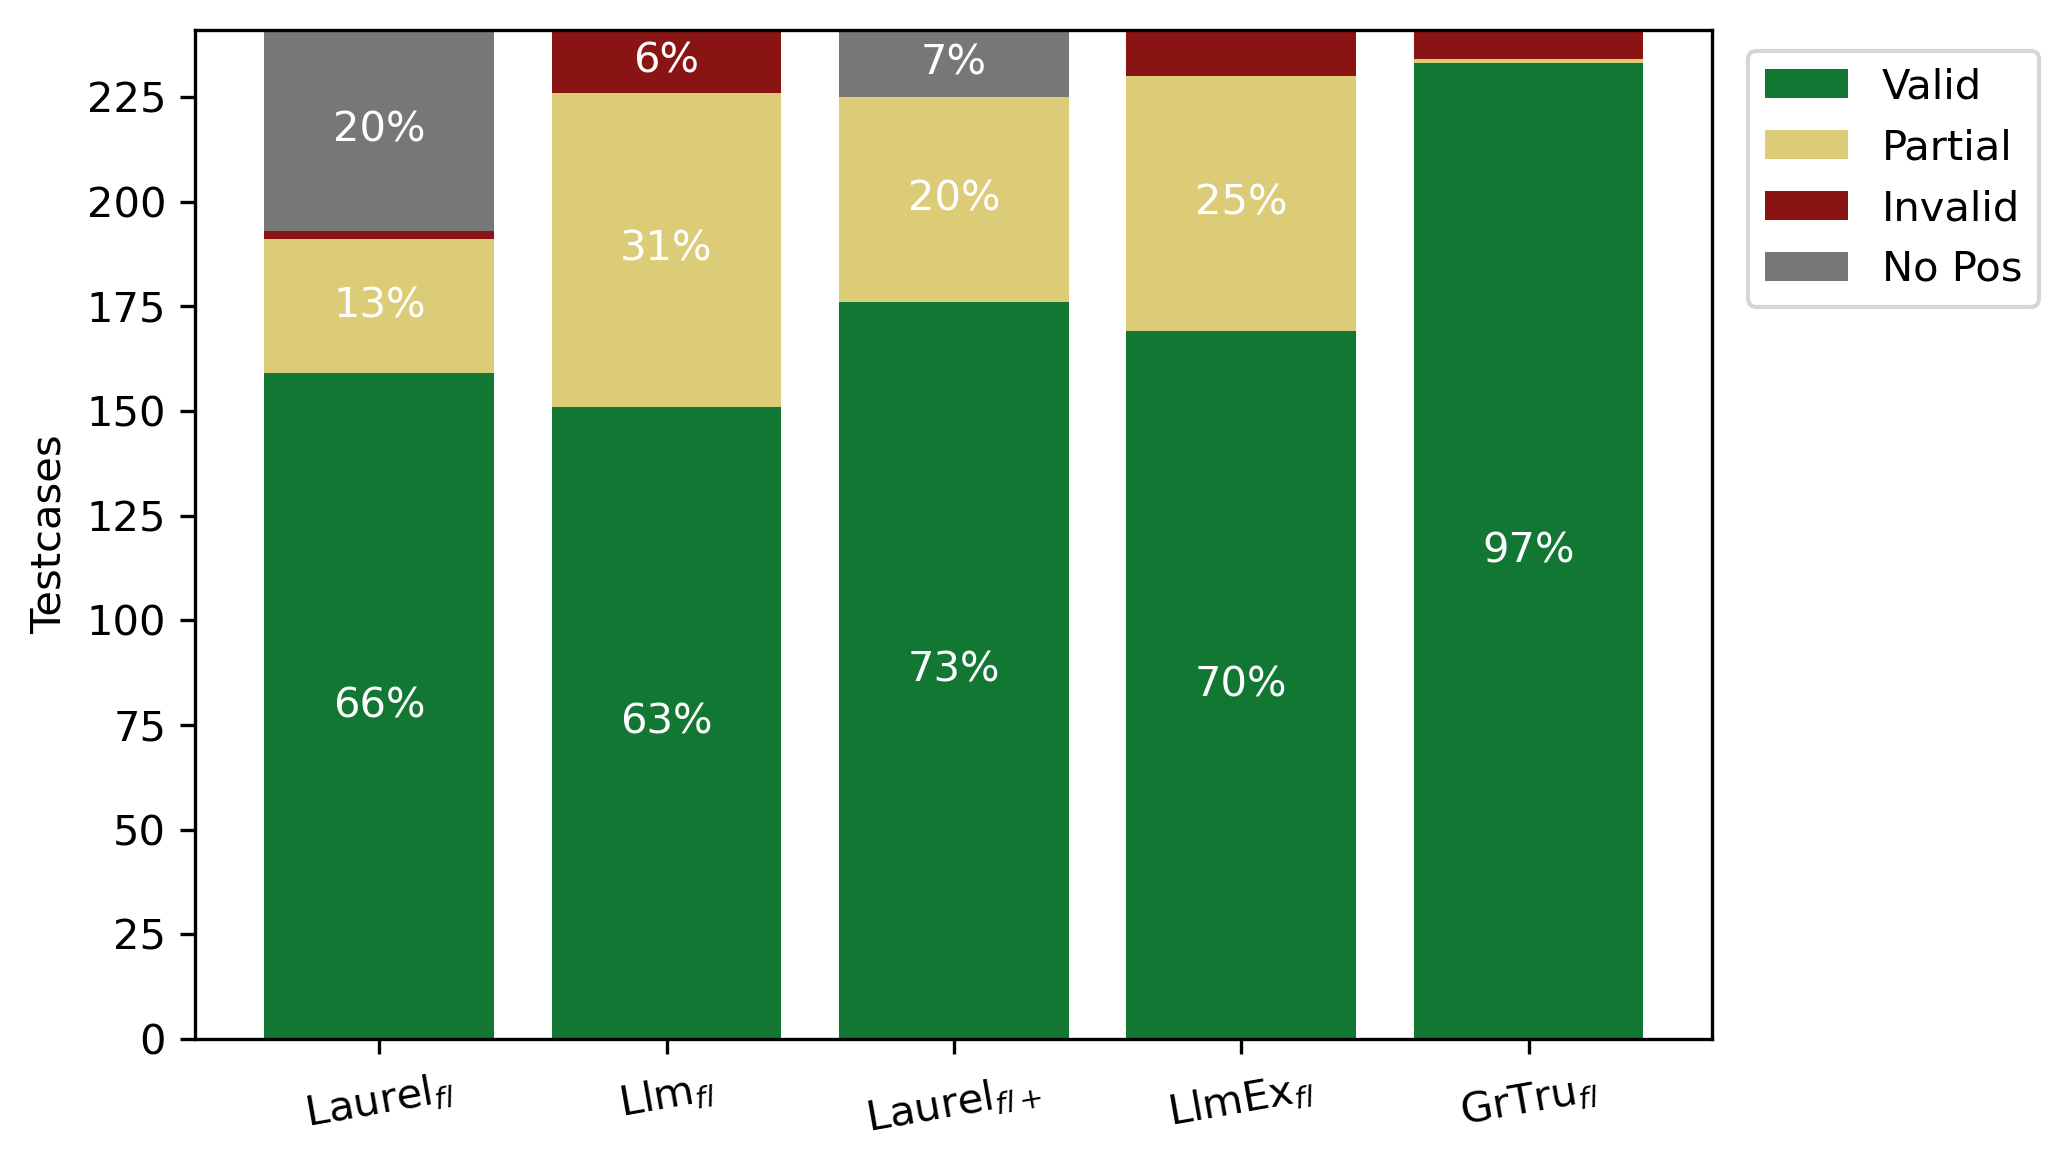

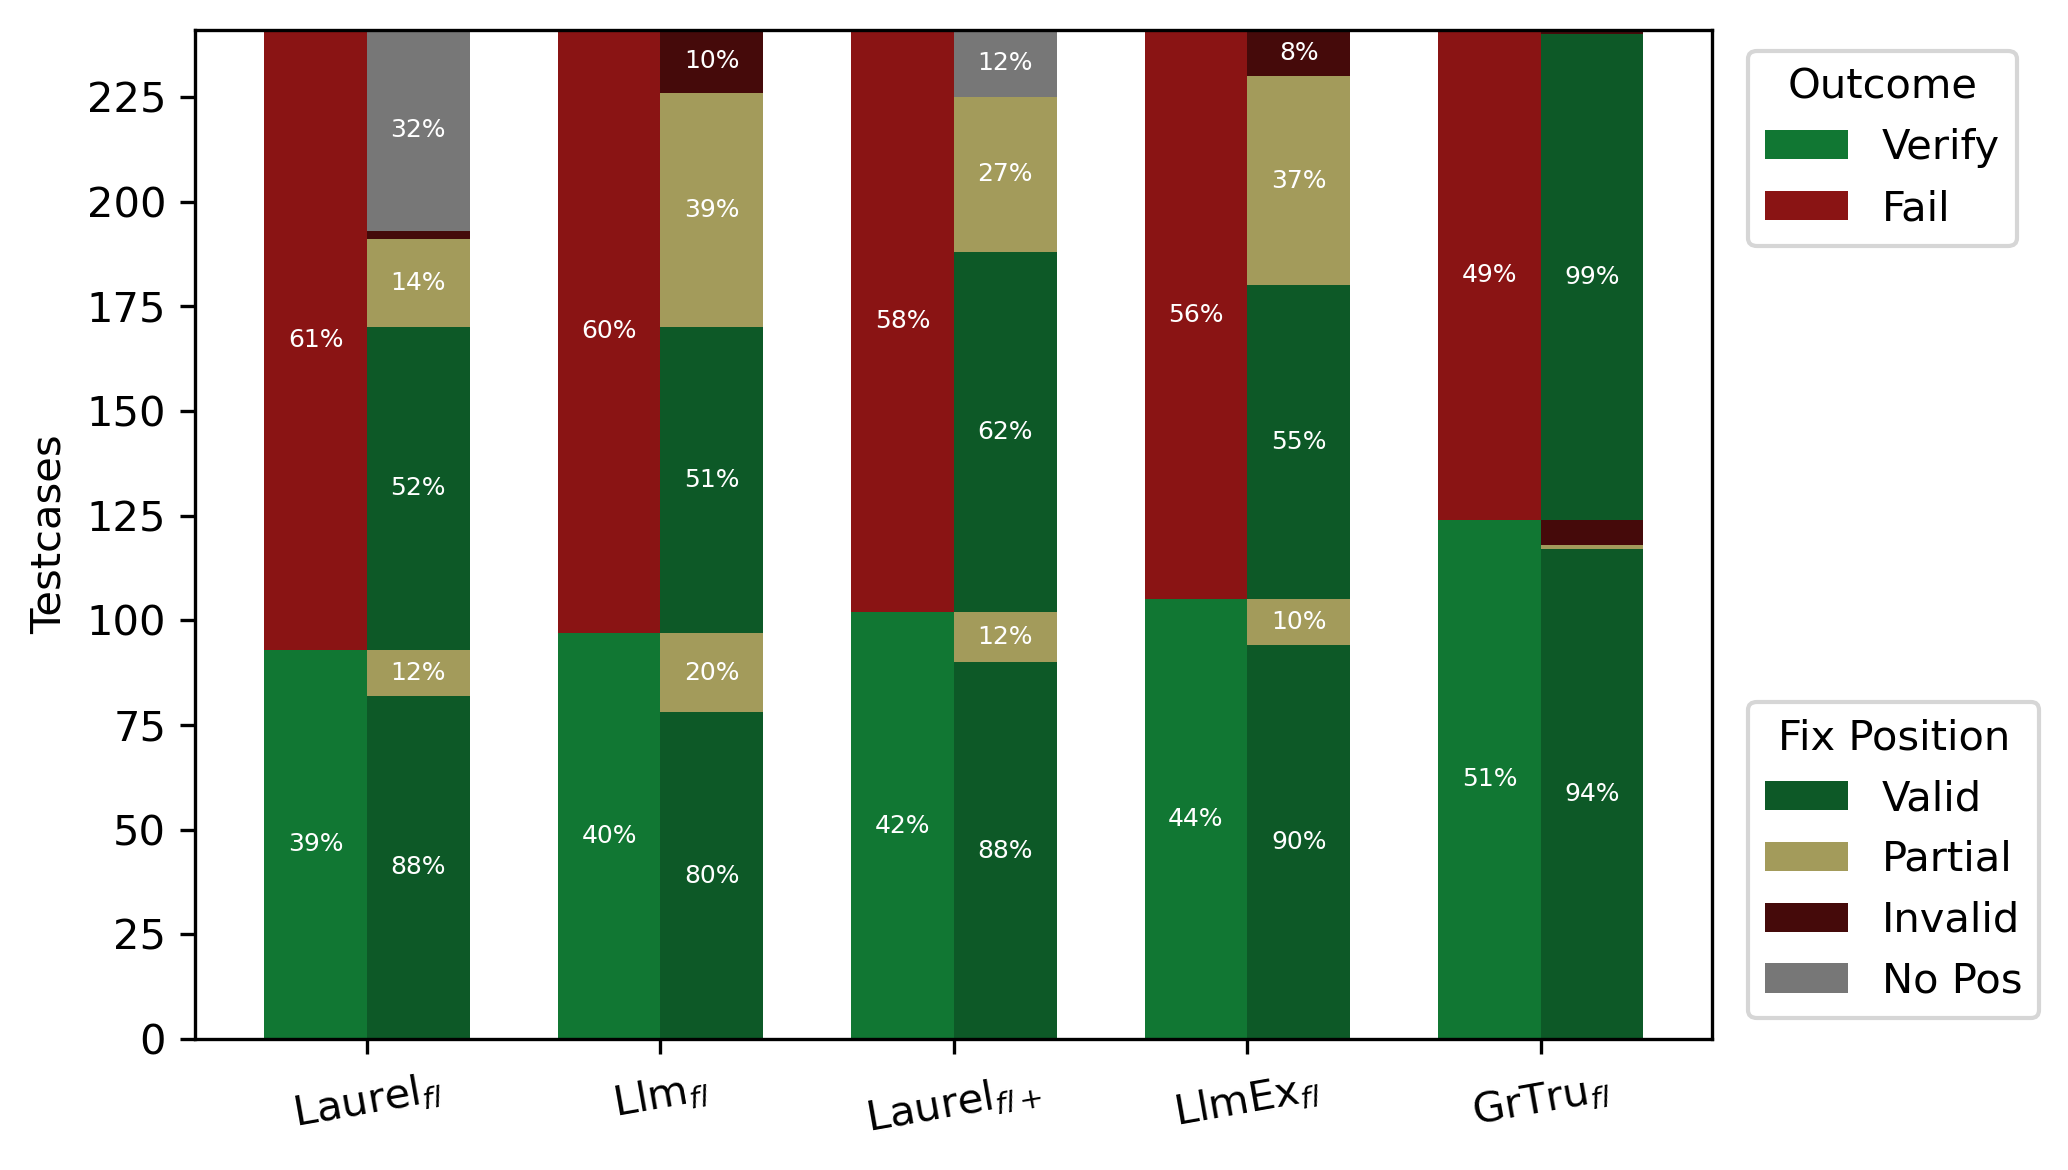

In [11]:
# Graphs of position evaluation
fault_loc_models={ 
                 "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_0_ExType_NONE_loc_LAUREL" : "Laurel$_{fl}$",
                 "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_0_ExType_NONE_loc_LLM" : "Llm$_{fl}$", 
                 "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_0_ExType_NONE_loc_LAUREL_BETTER" : "Laurel$_{fl+}$",
                 "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_0_ExType_NONE_loc_LLM_EXAMPLE" : "LlmEx$_{fl}$",
                 "gpt_4.1__nAssertions_ALL_nRounds_1_nRetries_1_addError_1_addExamp_0_ExType_NONE_loc_ORACLE" : "GrTru$_{fl}$",                                 
}

one_assertion_pd = verif_data_pd[verif_data_pd["benchmark"] == "w/o-1"]

dual_name = "1_assertion__evaluating_position_inference_without_examples_bar_chart_dual_success_fix.pdf"
single_name = "1_assertion__evaluating_position_inference_without_examples_bar_chart_fix_position_analysis.pdf"


images_p = gl.BASE_PATH / "images"
bar_chart_fix_position_cleaned(one_assertion_pd ,"DOUBLE",   fault_loc_models, images_p / single_name )
sucess_vs_position_cleaned(one_assertion_pd ,"DOUBLE",   fault_loc_models, images_p / dual_name)